# 1. Imports

In [49]:
# misc libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Utilities
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier


# 2. Dataset generation

## Constant and functions

In [50]:
ROOT_DIR= '/mnt/d/NOTES-ARCHIVE/PROJECT3/Code/Dataset_distilled'
LABELS= ["Benign","Bruteforce","Dos/DDos","Mirai","Recon","Spoofing","Web-based"]

In [51]:
single_value_cols = []
def is_unique(s):                           #   This runs in O(n) compared to O(n log n) nunique() method
    a = s.to_numpy() 
    return (a[0] == a).all()

In [52]:
def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    return 1

## Loading and dropping column with single-value

In [53]:
df = pd.read_csv(f'{ROOT_DIR}/dataset.csv')

In [54]:
for i in df.columns:
    if(is_unique(df[i])):
        single_value_cols.append(i)
df.drop(single_value_cols,axis=1, inplace=True) 

In [55]:
# Display the original class distribution
print(df['class'].value_counts(ascending=True))
print(type(df))

class
Bruteforce     7544
Benign        10000
Dos/DDos      10000
Spoofing      10000
Mirai         10000
Recon         10000
Web-based     10000
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>


<Axes: >

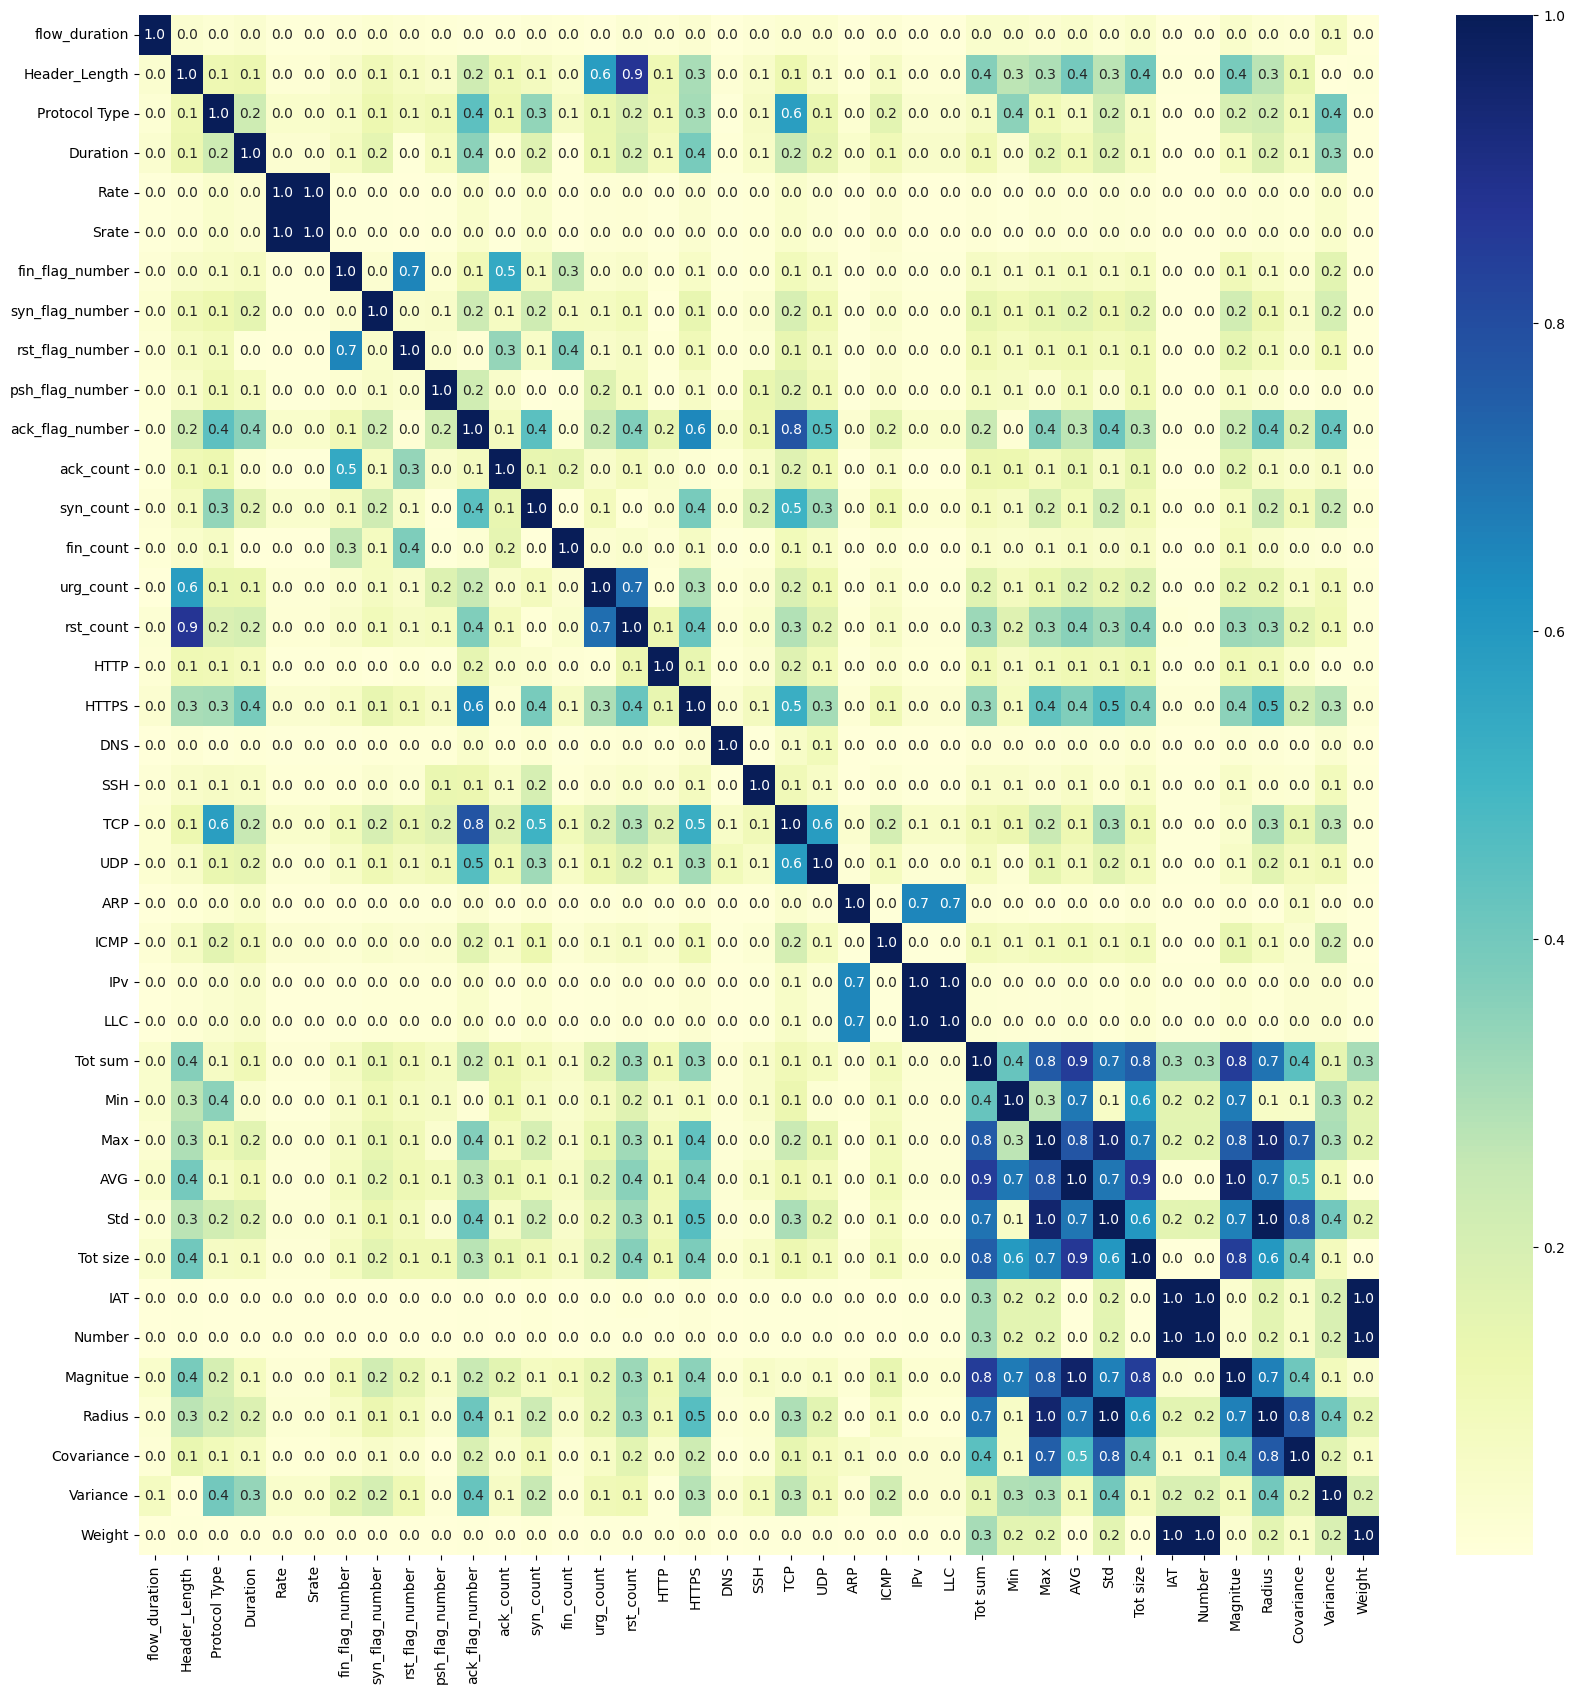

In [56]:
# Display the detailed correlation matrix.
corr = df.iloc[:,:-1].corr().abs()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".1f", cmap="YlGnBu")


In [57]:
# Display number of columns
num_columns = df.shape[1]

# Output the number of columns
print(f"The number of columns in the DataFrame is: {num_columns}")

The number of columns in the DataFrame is: 40


## Split into training and testing set

In [58]:
sub_df = df  

# remove nan, inf, -inf value
sub_df = sub_df[~sub_df.isin([np.nan, np.inf, -np.inf]).any(axis=1)] 
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [59]:
X = sub_df.iloc[:,:-1]
Y = sub_df.iloc[:,-1]

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=random.randint(1,999))
print(X_train.shape,X_test.shape)

(54035, 39) (13509, 39)


## Data scaling

In [61]:
scaler = StandardScaler()
# Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Instance selection K-means

In [62]:
def stratified_kmeans_sampling(df, label_column, n_samples_per_class):
    """
    Perform stratified k-means sampling on a DataFrame.    
    """
    sampled_rows = []
    scaler = StandardScaler()
    # Group the DataFrame by the label column
    grouped = df.groupby(label_column)
    
    for class_label, group in grouped:
        # Extract features for the current class (excluding the label column)
        X_class = group.drop(columns=[label_column]).values

        X_class= scaler.fit_transform(X_class)

        # Perform k-means clustering on the class data
        n_clusters = min(n_samples_per_class, len(X_class))  # Handle cases where class size < n_samples_per_class
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X_class)
        
        # Find the samples closest to the centroids
        centroids = kmeans.cluster_centers_
        closest_indices = []
        for centroid in centroids:
            distances = np.linalg.norm(X_class - centroid, axis=1)
            closest_index = np.argmin(distances)
            closest_indices.append(closest_index)
        
        # Append the selected rows from the original group
        sampled_rows.extend(group.iloc[closest_indices].values)
    
    # Return the condensed DataFrame
    condensed_df = pd.DataFrame(sampled_rows, columns=df.columns)
    return condensed_df

# Perform stratified k-means sampling
n_samples_per_class = 1000
condensed_df = stratified_kmeans_sampling(sub_df, label_column="class", n_samples_per_class=n_samples_per_class)

# Check the distribution of labels in the sampled DataFrame
print("Class distribution in the condensed dataset:")
print(condensed_df["class"].value_counts())

# (Optional) Display the condensed DataFrame


Class distribution in the condensed dataset:
class
Benign        1000
Bruteforce    1000
Dos/DDos      1000
Mirai         1000
Recon         1000
Spoofing      1000
Web-based     1000
Name: count, dtype: int64


In [63]:
# Seperate features and labels
X = condensed_df.iloc[:,:-1]
Y = condensed_df.iloc[:,-1]

In [64]:
print(Y.shape)

(7000,)


In [65]:
scaler = StandardScaler()
# Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X)

In [66]:
print(type(X_train_scaled))
print(X_train_scaled.shape)

<class 'numpy.ndarray'>
(7000, 39)


# 4. Random Forest

In [67]:
# RF_clf = RandomForestClassifier(n_estimators=200,max_depth=20, max_leaf_nodes=1000,n_jobs=-1)
RF_clf = RandomForestClassifier(n_estimators=1000,n_jobs=-1)
RF_clf.fit(X_train_scaled, Y)

RandomForestClassifier(n_estimators=1000, n_jobs=-1)

## Benchmarking

              precision    recall  f1-score   support

      Benign       0.63      0.07      0.12      2030
  Bruteforce       0.43      0.13      0.20      1509
    Dos/DDos       1.00      0.78      0.88      2020
       Mirai       0.86      0.99      0.92      2016
       Recon       0.40      0.38      0.39      1990
    Spoofing       0.46      0.46      0.46      1952
   Web-based       0.32      0.80      0.45      1992

    accuracy                           0.53     13509
   macro avg       0.59      0.52      0.49     13509
weighted avg       0.59      0.53      0.50     13509



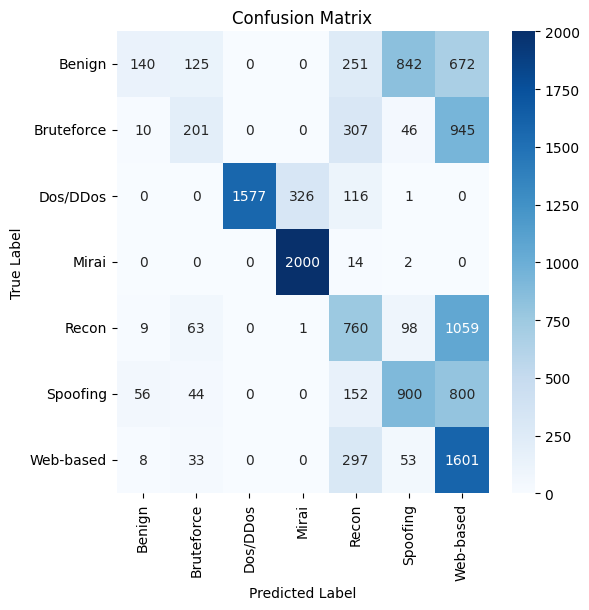

1

In [68]:
RF_clf_Y_pred = RF_clf.predict(X_test_scaled)
print(classification_report(Y_test, RF_clf_Y_pred))
plot_confusion_matrix(Y_test,RF_clf_Y_pred)
# ConfusionMatrixDisplay.from_predictions(Y_test, RF_clf_Y_pred, normalize='true',values_format='.2f', xticks_rotation='vertical')

# 5. MLP

## Training

In [69]:
mlp = MLPClassifier(
  hidden_layer_sizes=(128,),
  activation='relu',
  alpha=0.0001,
  solver='adam',
  learning_rate='constant',
  learning_rate_init=0.0002,
  max_iter=10000,
  random_state=42
)
mlp.fit(X_train_scaled, Y)

MLPClassifier(hidden_layer_sizes=(128,), learning_rate_init=0.0002,
              max_iter=10000, random_state=42)

## Benchmark

              precision    recall  f1-score   support

      Benign       0.78      0.51      0.61      2030
  Bruteforce       0.57      0.37      0.45      1509
    Dos/DDos       1.00      1.00      1.00      2020
       Mirai       0.99      1.00      0.99      2016
       Recon       0.57      0.60      0.59      1990
    Spoofing       0.71      0.63      0.67      1952
   Web-based       0.50      0.83      0.62      1992

    accuracy                           0.72     13509
   macro avg       0.73      0.71      0.70     13509
weighted avg       0.74      0.72      0.71     13509



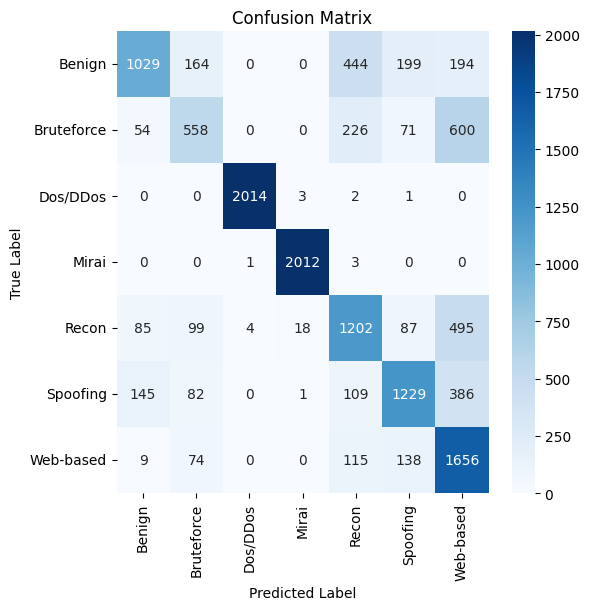

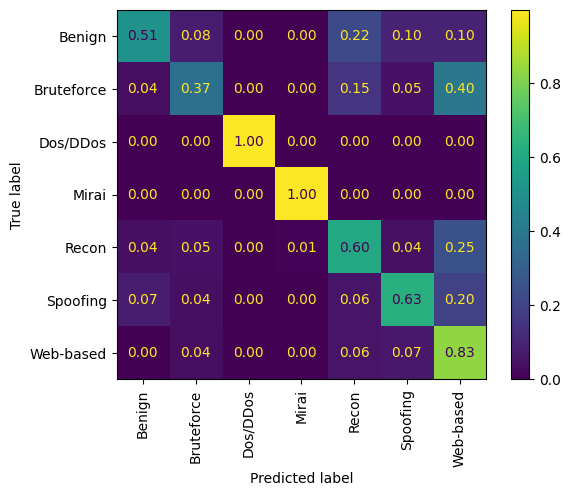

In [70]:
MLP_clf_Y_pred = mlp.predict(X_test_scaled)
print(classification_report(Y_test, MLP_clf_Y_pred))
plot_confusion_matrix(Y_test,MLP_clf_Y_pred)
ConfusionMatrixDisplay.from_predictions(Y_test, MLP_clf_Y_pred, normalize='true',values_format='.2f', xticks_rotation='vertical')

# 6. SGDC Classifier

## Training

In [71]:
param_grid = {
    'alpha': [1e-4, 1e-3, 1e-2],
    'loss': ['hinge', 'log', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'adaptive'],
    'eta0': [0.01, 0.1, 1.0],
}

sgd = SGDClassifier(random_state=42)
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, Y)

print("Best Parameters:", grid_search.best_params_)

/home/gray/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/gray/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/gray/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/gray/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/gray/tensorflow/lib/py

Best Parameters: {'alpha': 0.0001, 'eta0': 1.0, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'penalty': 'elasticnet'}


In [75]:
SGDC_clf = SGDClassifier(eta0=1.0,penalty='elasticnet',learning_rate='adaptive',alpha=0.0001,max_iter=10000, tol=1e-9,n_jobs=-1)
SGDC_clf.fit(X_train_scaled,Y)

SGDClassifier(eta0=1.0, learning_rate='adaptive', max_iter=10000, n_jobs=-1,
              penalty='elasticnet', tol=1e-09)

## Benchmark

              precision    recall  f1-score   support

      Benign       0.71      0.63      0.67      2030
  Bruteforce       0.73      0.18      0.29      1509
    Dos/DDos       0.83      0.97      0.90      2020
       Mirai       0.95      0.99      0.97      2016
       Recon       0.25      0.70      0.37      1990
    Spoofing       0.66      0.44      0.53      1952
   Web-based       0.00      0.00      0.00      1992

    accuracy                           0.57     13509
   macro avg       0.59      0.56      0.53     13509
weighted avg       0.59      0.57      0.54     13509



/home/gray/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gray/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gray/tensorflow/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


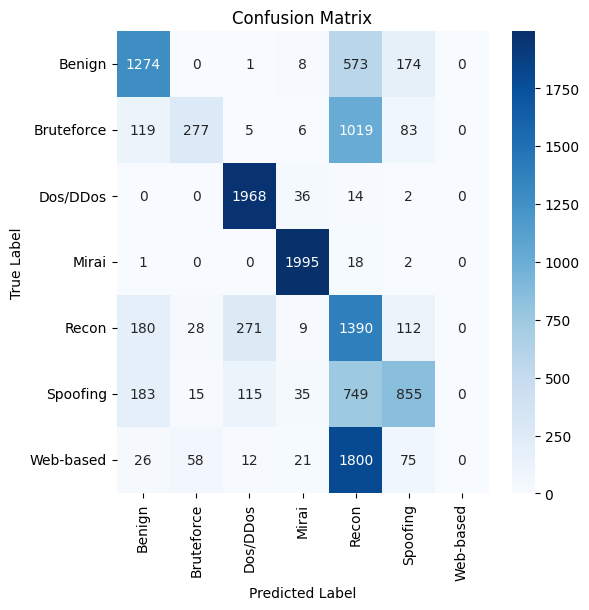

1

In [76]:
SGDC_clf_Y_pred = SGDC_clf.predict(X_test_scaled)
print(classification_report(Y_test, SGDC_clf_Y_pred))
plot_confusion_matrix(Y_test,SGDC_clf_Y_pred)
# ConfusionMatrixDisplay.from_predictions(Y_test, SGDC_clf_Y_pred, normalize='true',values_format='.2f', xticks_rotation='vertical')